<a href="https://colab.research.google.com/github/scudjoeDS/scudjoeDS/blob/main/Malaria%20Detection-%20Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mounting the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing libraries required to load the data
import zipfile

import os

import cv2

from PIL import Image  # resize image

import numpy as np
np.random.seed(1000)

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

# To ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)

pd.set_option("display.max_rows", 200)

**Loading Data**

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Capstone Dataset-zip/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall()



The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.


In [ ]:
# Storing the path of the extracted "train" folder
train_dir = '/content/cell_images/train'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [ ]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:

    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:

            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':

                train_labels.append(1)

            else:

                train_labels.append(0)

        except Exception:

            pass

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

In [ ]:
# Storing the path of the extracted "test" folder
test_dir = '/content/cell_images/test'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [ ]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:

    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':

                test_labels.append(1)

            else:

                test_labels.append(0)

        except Exception:

            pass

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

**Checking the number of images in the training and the testing dataset.**

In [ ]:
len(train_images), len(test_images)

(24958, 2600)

**Observation:**

    There are 24958 images in the training data and 2600 images in the testing data.



**Checking the shape of train and test images and labels**

In [ ]:
print("Train shape: {}". format(train_images.shape))
print("Test shape: {}".  format(test_images.shape))
print("Train labels: {}".format(train_labels.shape))
print("Test labels: {}". format(test_labels.shape))


Train shape: (24958, 64, 64, 3)
Test shape: (2600, 64, 64, 3)
Train labels: (24958,)
Test labels: (2600,)


**Observations and insights:**
Both the train and test images have the same size of (64,64,3). There are 24958 train labels and 2600 test labels.

**Checking the minimum and maximum range of pixel values for train and test images**

In [ ]:
print('Min: %.0f, Max: %.0f' % (train_images.min(), train_images.max()))
print('Min: %.0f, Max: %.0f' % (test_images.min(), test_images.max()))

Min: 0, Max: 255
Min: 0, Max: 255


**Observation:**
The minimum and maximum pixel values are printed, showing the expected 0 and 255, respectively.

**Count the number of values in both uninfected and parasitized**

In [ ]:
print('train_images \n',pd.DataFrame(train_labels).value_counts())
print('test_images \n',pd.DataFrame(test_labels).value_counts())

train_images 
 1    12582
0    12376
dtype: int64
test_images 
 0    1300
1    1300
dtype: int64


There are 12,582 Parasitized Images as opposed to 12376 Uninfected Images in the Train Folder; uneven number of images- may need Data Augumentation.

However, there are equal number of images for both Parasitized and Uninfected in the Test Folder.

**Checking if data is balanced**

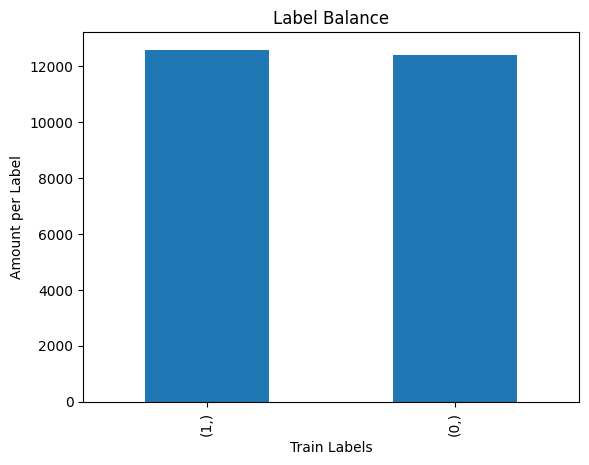

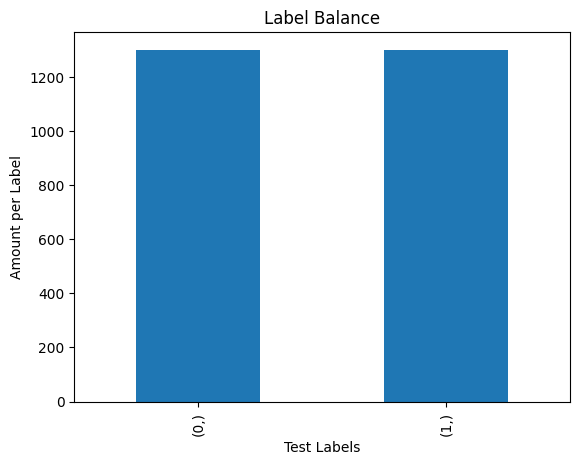

In [ ]:
# Train Labels
y_train=pd.DataFrame(train_labels)
y_train.value_counts().plot(kind='bar')
plt.title('Label Balance')
plt.xlabel('Train Labels')
plt.ylabel('Amount per Label')
plt.show()

# Test Labels
y_test=pd.DataFrame(test_labels)
y_test.value_counts().plot(kind='bar')
plt.title('Label Balance')
plt.xlabel('Test Labels')
plt.ylabel('Amount per Label')
plt.show()

**Observation:**

Visualizing cell images; in the graph above, 0 indicates uninfected, while 1 indicates parasitized cells.

 **Normalizing Images and Converting them to float32**


In [ ]:
# Try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function

# Normalize inputs from 0-255 to 0-1

train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')


In [ ]:
# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import *# pipelines
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline# data preparation
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import resample
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE# machine learning
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical

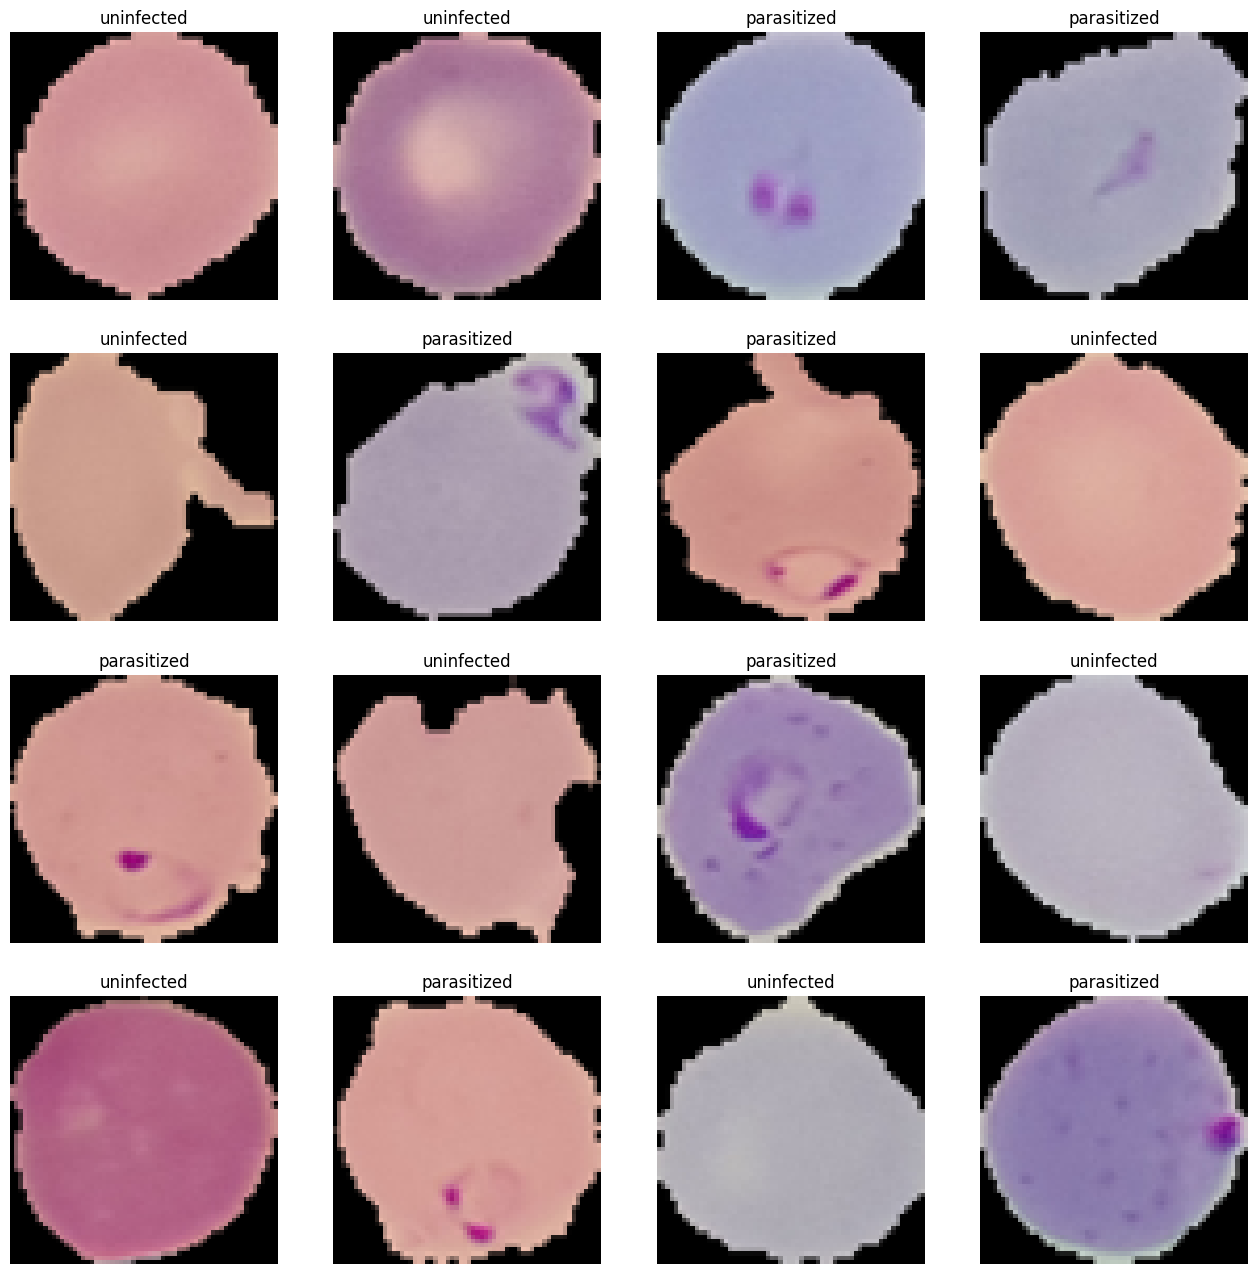

In [ ]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)

plt.figure(1, figsize = (16 , 16))

for n in range(1, 17):

    plt.subplot(4, 4, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

**Observation:**

Based on the sample images above, we can notice some subtle differences between parasitized and uninfected cell images. We will basically make our deep learning models try and learn these patterns during model training.

**Similarly visualize the images with subplot(6, 6) and figsize = (12, 12)**

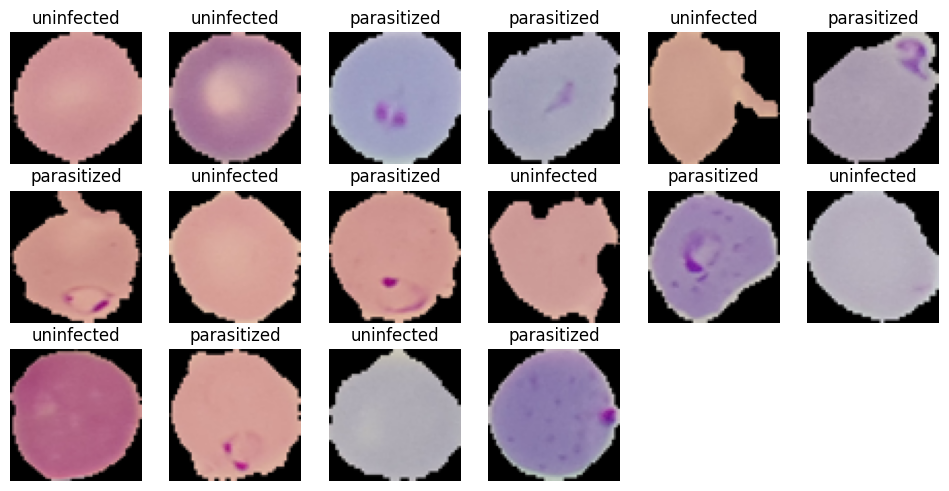

In [ ]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)

plt.figure(1, figsize = (12 , 12))

for n in range(1, 17):

    plt.subplot(6, 6, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

**Observation**

**Plotting the mean images for parasitized and uninfected**

In [ ]:
# Function to find the mean
def find_mean_img(full_mat, title):

    # Calculate the average
    mean_img = np.mean(full_mat, axis = 0)[0]


    # Reshape it back to a matrix
    plt.imshow(mean_img)

    plt.title(f'Average {title}')

    plt.axis('off')

    plt.show()

    return mean_img

**Mean image for parasitized**

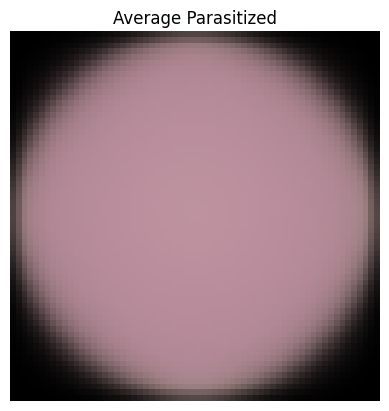

0.5041269332478564

In [ ]:
# If the label = 1 then the image is parasitised and if the label = 0 then the image is uninfected
parasitized_data = []  # Create a list to store the parasitized data

for img, label in zip(train_images, train_labels):

        if label == 1:

              parasitized_data.append([img])

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean

np.mean(train_labels)






**Mean image for uninfected**


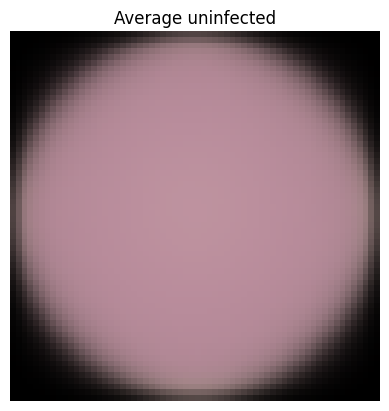

0.5041269332478564

In [ ]:
# If the label = 1 then the image is parasitised and if the label = 0 then the image is uninfected
uninfected_data = []  # Create a list to store the parasitized data

for img, label in zip(train_images, train_labels):

        if label == 1:

              uninfected_data.append([img])

uninfected_mean = find_mean_img(np.array(uninfected_data), 'uninfected')   # find the


np.mean(train_labels)


**Observation:**

**Converting RGB to HSV of Images using OpenCV**

*Converting the train data *


In [ ]:
import cv2

gfx=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

  a = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2HSV)

  gfx.append(a)

gfx = np.array(gfx)

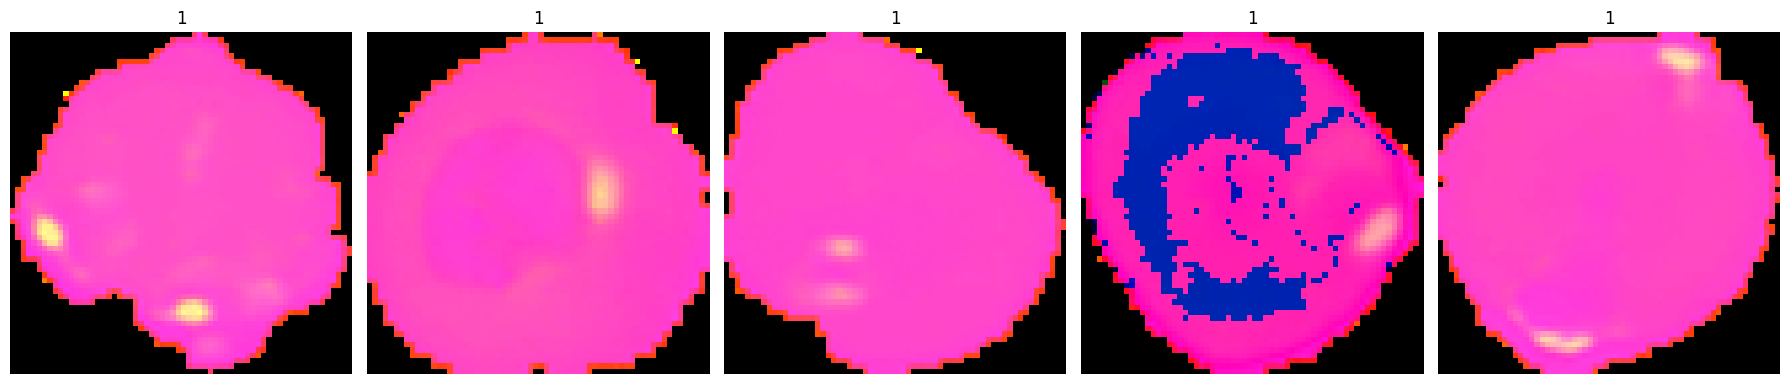

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(gfx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

***Converting the test data***

In [ ]:
import cv2

gfx=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

  a = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2HSV)

  gfx.append(a)

gfx = np.array(gfx)

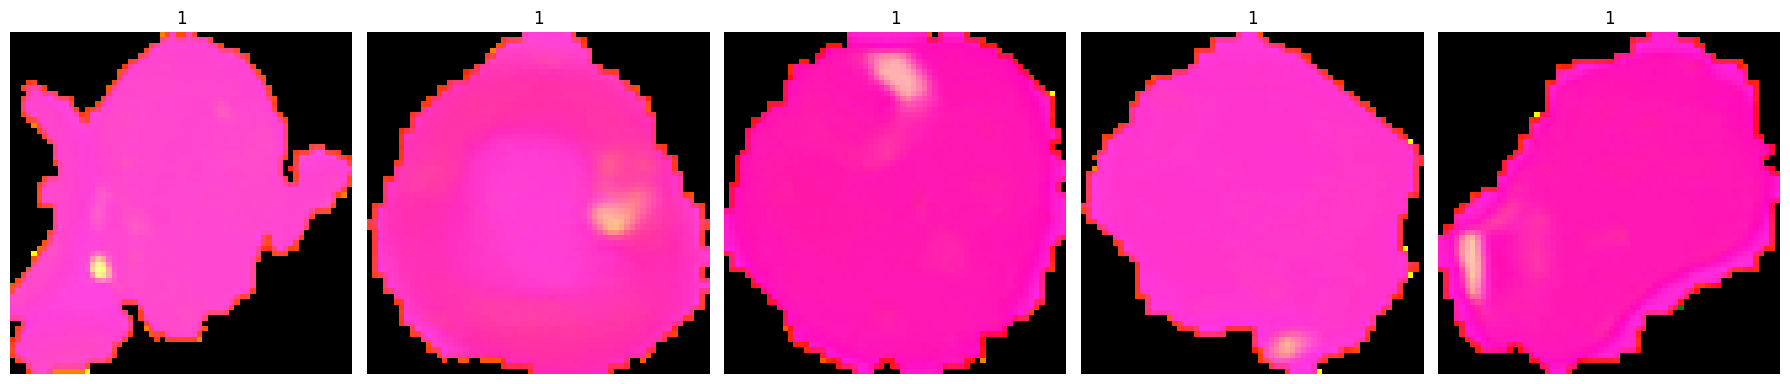

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(gfx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

## **Processing Images using Gaussian Blurring**

**Gaussian Blurring on train data**

In [ ]:
gbx = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(train_images[i], (5, 5), 0)

  gbx.append(b)

gbx = np.array(gbx)

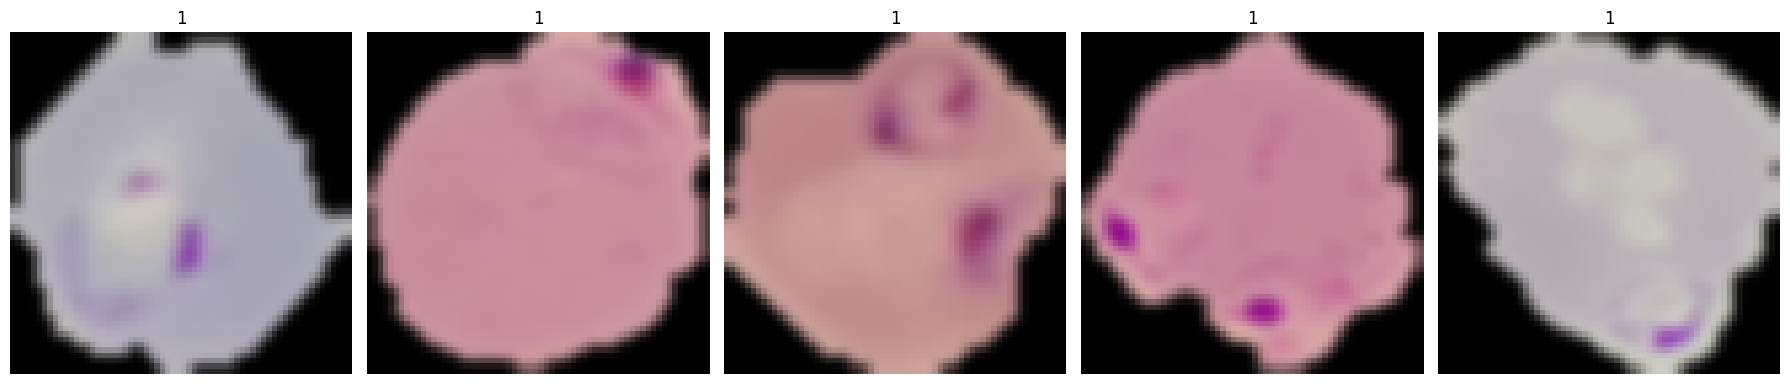

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)


  ax[t].imshow(gbx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

**Gaussian Blurring on test data**

In [ ]:
gbx = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(test_images[i], (5, 5), 0)

  gbx.append(b)

gbx = np.array(gbx)

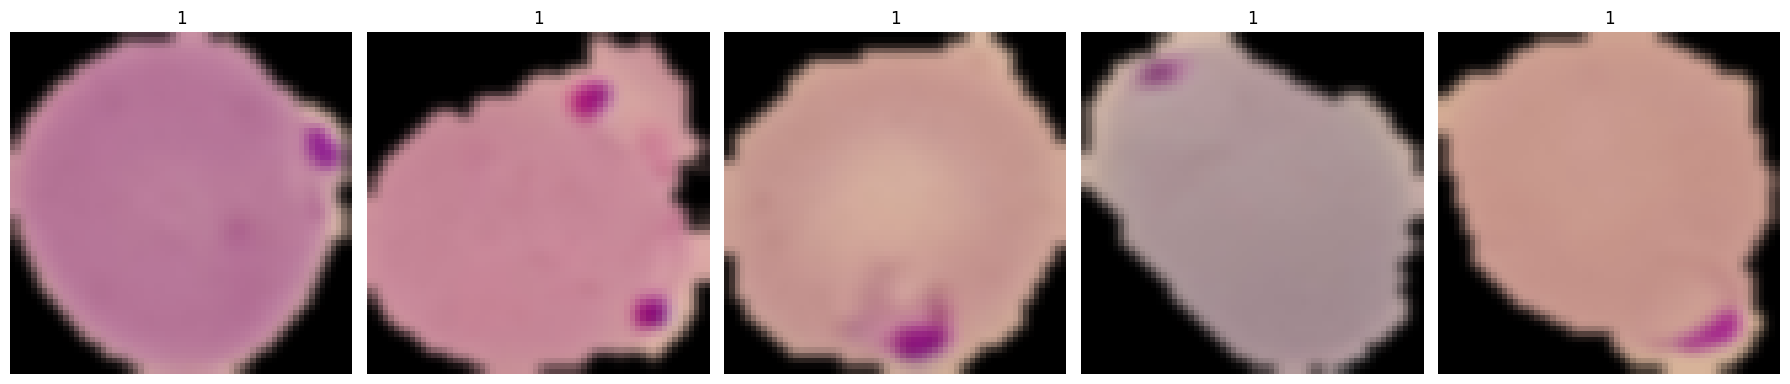

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)


  ax[t].imshow(gbx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

Gaussian Blurring uses weighted mean, where neighborhood pixels that are closer to the central pixel contribute more “weight” to the average.
The end result is that our image is less blurred, but more “naturally blurred,” than using the average method. Furthermore, based on this weighting we are able to preserve more of the edges in our image as compared to average smoothing.

We can try out **Bilateral Blurring** to reduce noise while still maintaining edges.

**One Hot Encoding on the train and test labels**

In [ ]:
# Encoding Train Labels
train_labels = to_categorical(train_labels, 2)

# Similarly let us try to encode test labels
test_labels = to_categorical(test_labels, 2)

**Base Model**

 The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

In [ ]:
# Clearing backend
import tensorflow as tf
from tensorflow.keras import backend

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from random import shuffle

backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

**Building the model**

In [ ]:
# Creating sequential model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation = "relu"))

model.add(Dropout(0.4))

model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

**Compiling the model**

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

**Using Callbacks **

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

**Fit and train our Model**

In [ ]:
# Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ]
history = model.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 116s 183ms/step - loss: 0.3566 - accuracy: 0.8362 - val_loss: 0.1420 - val_accuracy: 0.9497
Epoch 2/20
624/624 [==============================] - 116s 186ms/step - loss: 0.1266 - accuracy: 0.9540 - val_loss: 0.1568 - val_accuracy: 0.9631
Epoch 3/20
624/624 [==============================] - 111s 178ms/step - loss: 0.0984 - accuracy: 0.9680 - val_loss: 0.0854 - val_accuracy: 0.9860
Epoch 4/20
624/624 [==============================] - 116s 186ms/step - loss: 0.0719 - accuracy: 0.9757 - val_loss: 0.0986 - val_accuracy: 0.9776
Epoch 5/20
624/624 [==============================] - 112s 179ms/step - loss: 0.0695 - accuracy: 0.9767 - val_loss: 0.0728 - val_accuracy: 0.9860
Epoch 6/20
624/624 [==============================] - 116s 185ms/step - loss: 0.0655 - accuracy: 0.9774 - val_loss: 0.0789 - val_accuracy: 0.9840
Epoch 7/20
624/624 [==============================] - 113s 181ms/step - loss: 0.0637 - accuracy: 0.9771 - val_loss: 0.0800 -

**Evaluating the model on test data**

In [ ]:
accuracy = model.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 5s 55ms/step - loss: 0.0578 - accuracy: 0.9838

 Test_Accuracy:- 0.983846127986908


**Plotting the confusion matrix**

82/82 [==============================] - 3s 38ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



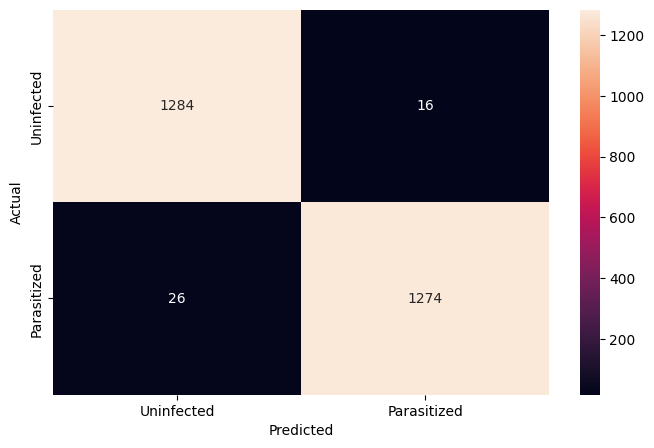

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

**Plotting the train and validation curves**

In [ ]:
# Function to plot train and validation accuracy
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

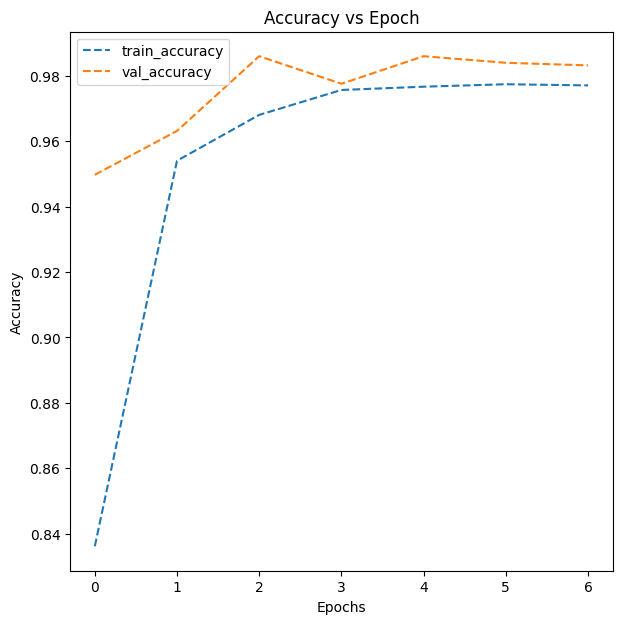

In [ ]:
plot_accuracy(history)


    Here we can clearly observe that the training and valiation accuracy are increasing
    And we can also notice that validation accuracy is slightly higher than the train accuracy

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.


**Trying to improve the performance of Model 1 by adding new layers**


In [ ]:
backend.clear_session() # Clearing the backend for new model

In [ ]:
#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.layers import LeakyReLU
from keras.optimizers import SGD

# Creating sequential model
model1 = Sequential()

# Adding layers

model1.add(Convolution2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model1.add(Convolution2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))


model1.add(Convolution2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model1.add(Convolution2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.5))

model1.add(Convolution2D(filters = 96, kernel_size = 3, dilation_rate=(2, 2), padding = "same", activation = "relu"))
model1.add(Convolution2D(filters = 96, kernel_size = 3, dilation_rate=(2, 2), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.5))

model1.add(Flatten())

model1.add(Dense(512, activation = "relu"))

model1.add(Dropout(0.4))

model1.add(Dense(256, activation = "relu"))

model1.add(Dropout(0.4))

model1.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

**Compiling the model with additional layers**

In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

**Using Callbacks**

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

**Fit and Train the model**


In [ ]:
# Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ]
history1 = model1.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
624/624 [==============================] - 740s 1s/step - loss: 0.1668 - accuracy: 0.9330 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 2/10
624/624 [==============================] - 715s 1s/step - loss: 0.0860 - accuracy: 0.9715 - val_loss: 0.0450 - val_accuracy: 0.9870
Epoch 3/10
624/624 [==============================] - 701s 1s/step - loss: 0.0781 - accuracy: 0.9750 - val_loss: 0.0365 - val_accuracy: 0.9876


**Evaluating the model**

In [ ]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 24s 297ms/step - loss: 0.0638 - accuracy: 0.9831

 Test_Accuracy:- 0.9830769300460815


**Plotting the confusion matrix**

82/82 [==============================] - 25s 295ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



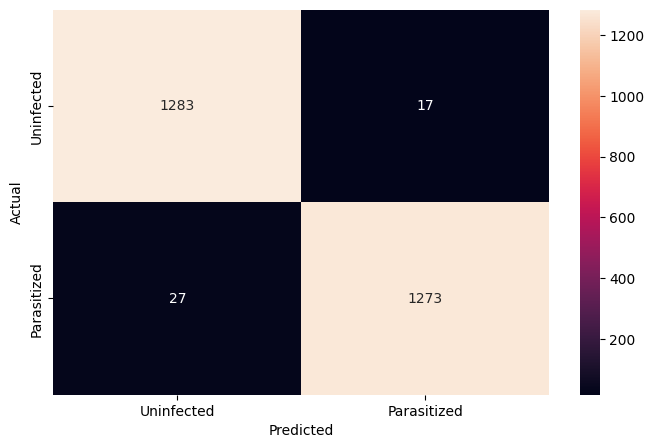

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred1 = model1.predict(test_images)

pred1 = np.argmax(pred1, axis = 1)

y_true1 = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true1, pred1))

# Plotting the heatmap using confusion matrix
cm1 = confusion_matrix(y_true1, pred1)

plt.figure(figsize = (8, 5))

sns.heatmap(cm1, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

**Plotting the train and the validation curves**

In [ ]:
# Function to plot train and validation accuracy
def plot_accuracy(history1):

    N1 = len(history1.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N1), history1.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N1), history1.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

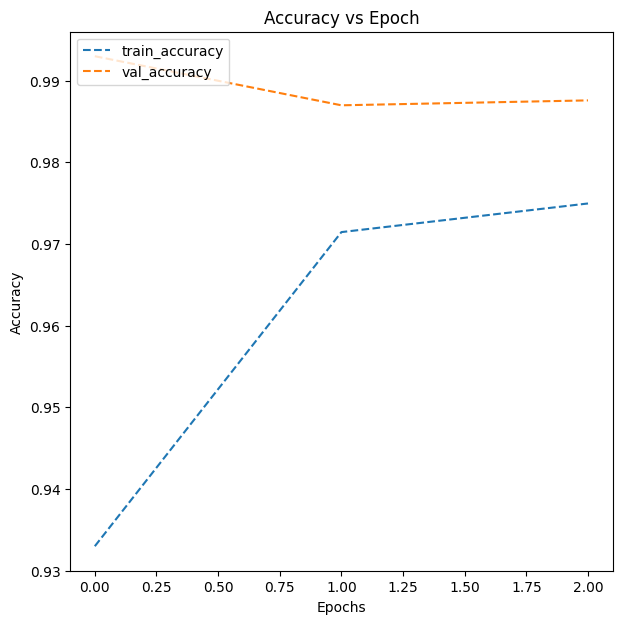

In [ ]:
plot_accuracy(history1)

###Think about it:
Now let's build a model with LeakyRelu as the activation function

    Can the model performance be improved if we change our activation function to LeakyRelu?
    Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.


**Model 2**

In [ ]:
backend.clear_session() # Clearing the backend for new model

In [ ]:
#Importing losses and optimizers modules
from tensorflow.keras import losses
from tensorflow.keras import optimizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.layers import LeakyReLU
from keras.optimizers import SGD

model2 = Sequential()

model2.add(Convolution2D(filters = 32, kernel_size = 2, padding = "same",  input_shape = (64, 64, 3)))
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(Dropout(0.2))

model2.add(Convolution2D(32, (3, 3), input_shape = (64, 64, 3), padding = 'same'))
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

model2.add(Convolution2D(filters = 32, kernel_size = 2, padding = "same"))
model2.add(LeakyReLU(0.1))
model2.add(MaxPooling2D(pool_size = 2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

model2.add(Flatten())

model2.add(Dense(512))

model2.add(Dropout(0.4))

model2.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons


adam = optimizers.Adam(learning_rate = 0.001)


model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                        

**Compiling Model 2**

In [ ]:
model2.compile(loss = "binary_crossentropy", optimizer = adam, metrics = ['accuracy'])

**Using Callbacks**

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

**Fit and train the model**

In [ ]:
history2 = model2.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
624/624 [==============================] - 184s 284ms/step - loss: 0.8462 - accuracy: 0.6483 - val_loss: 0.3894 - val_accuracy: 0.9657
Epoch 2/10
624/624 [==============================] - 167s 268ms/step - loss: 0.4344 - accuracy: 0.7951 - val_loss: 0.0231 - val_accuracy: 0.9988
Epoch 3/10
624/624 [==============================] - 166s 265ms/step - loss: 0.1955 - accuracy: 0.9265 - val_loss: 0.0364 - val_accuracy: 0.9958
Epoch 4/10
624/624 [==============================] - 164s 262ms/step - loss: 0.1445 - accuracy: 0.9517 - val_loss: 0.0425 - val_accuracy: 0.9948


**Evaluating the model**

In [ ]:
accuracy2 = model2.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy2[1])

82/82 [==============================] - 5s 58ms/step - loss: 0.0972 - accuracy: 0.9665

 Test_Accuracy:- 0.9665384888648987


**Plotting the confusion matrix**

82/82 [==============================] - 5s 57ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1300
           1       0.99      0.94      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



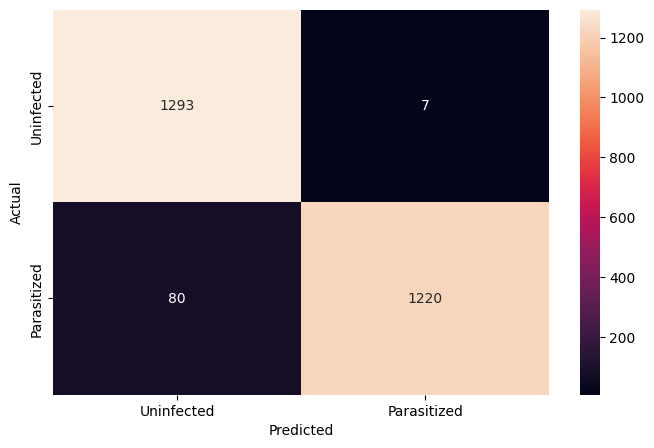

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred2 = model2.predict(test_images)

pred2 = np.argmax(pred2, axis = 1)

y_true2 = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true2, pred2))

# Plotting the heatmap using confusion matrix
cm2 = confusion_matrix(y_true2, pred2)

plt.figure(figsize = (8, 5))

sns.heatmap(cm2, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

**Plotting the train and validation accuracy**


In [ ]:
# Plotting the accuracies

def plot_accuracy(history2):

    N2 = len(history2.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N2), history2.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N2), history2.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

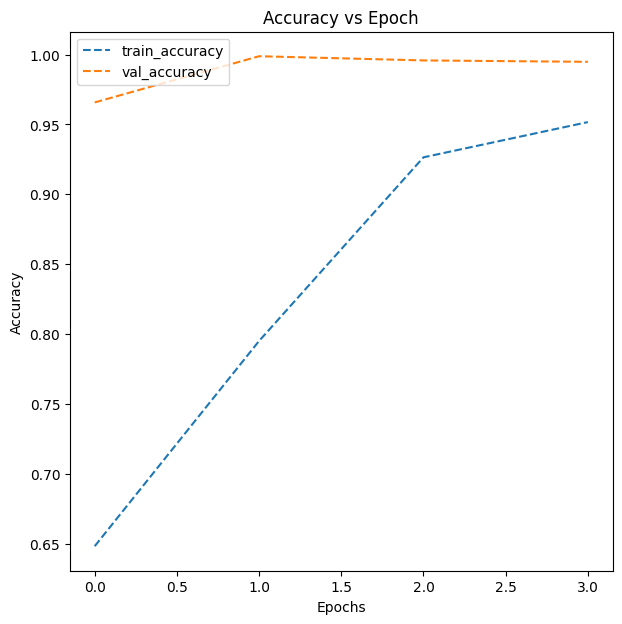

In [ ]:
plot_accuracy(history2)

###Think About It :

    Can we improve the model with Image Data Augmentation?
    References to image data augmentation can be seen below:
        Image Augmentation for Computer Vision
        How to Configure Image Data Augmentation in Keras?



**Model 3 with Data Augmentation**

In [ ]:
backend.clear_session() # Clearing backend for new model

**Using image data generator**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                  zoom_range = 0.5, rotation_range = 30)

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = train_images, y = train_labels, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x =train_images, y = train_labels, batch_size = 64, seed = 42, shuffle = True)

**Visualizing Augmented images**

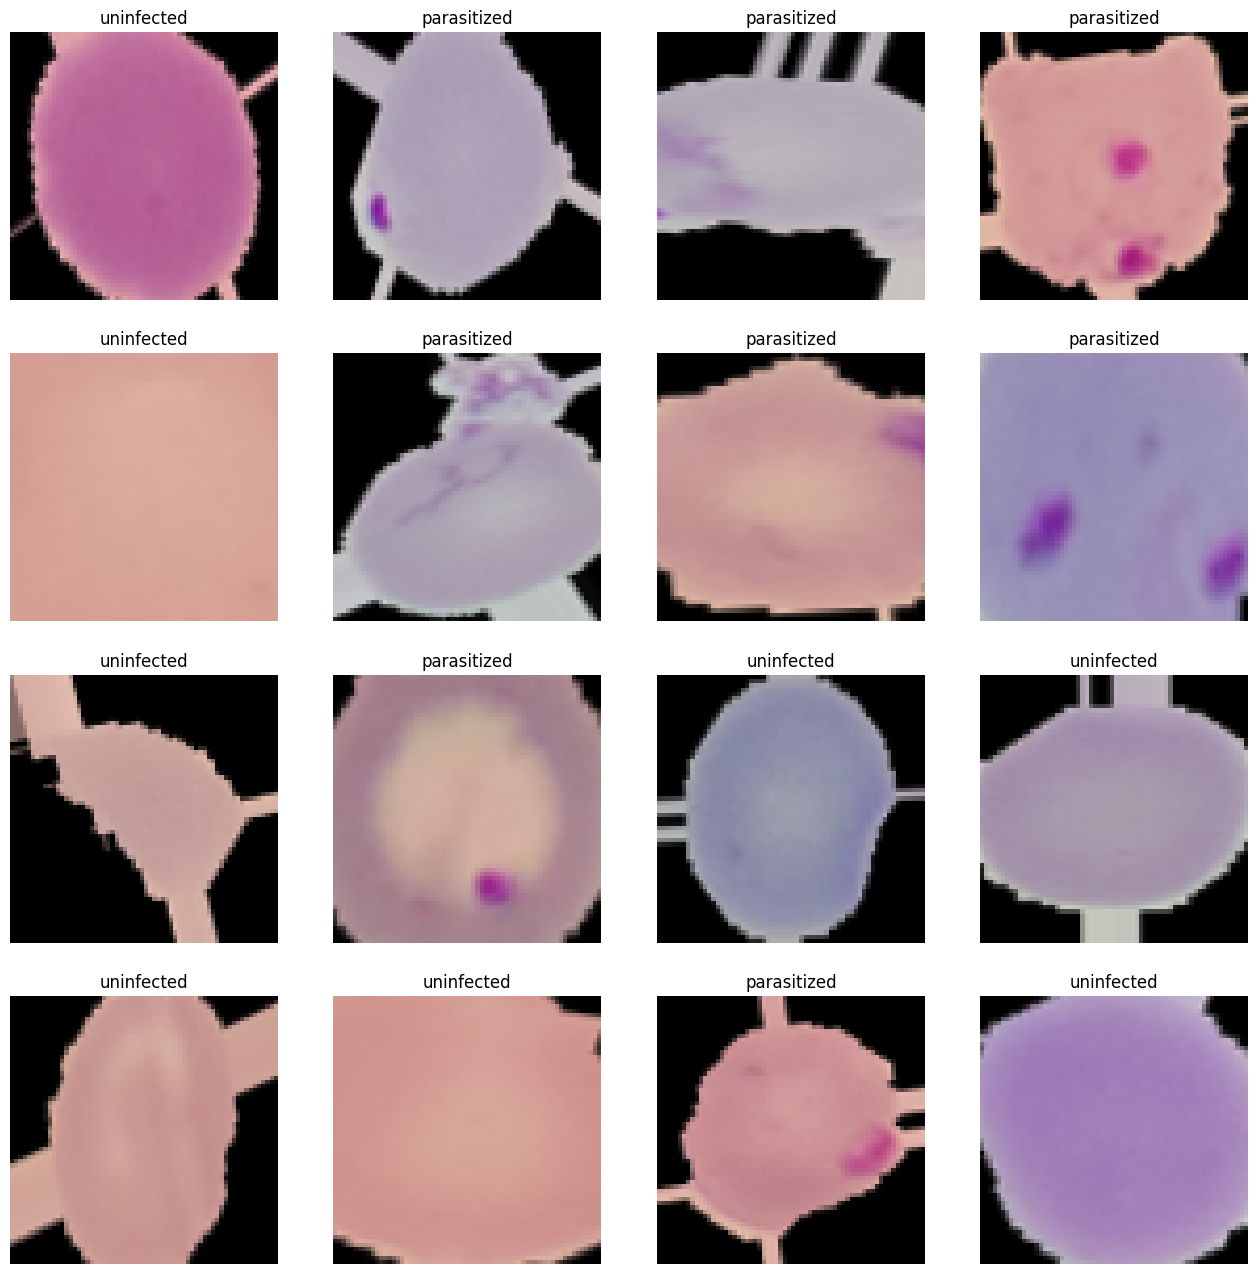

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1:

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

**Building Model 3**

In [ ]:
model3 = Sequential()


model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(512, activation = "relu"))

model3.add(Dropout(0.4))

model3.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model3.compile(loss = "binary_crossentropy" , optimizer = adam, metrics = ['accuracy'])

model3.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

**Using callbacks**

In [ ]:
  callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
               ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

**Fit and Train the model**

In [ ]:

history3 = model3.fit(train_generator,  validation_data = val_generator, batch_size = 64, callbacks = callbacks,
                                  epochs = 10, verbose = 1)

Epoch 1/10
390/390 [==============================] - 219s 557ms/step - loss: 0.5710 - accuracy: 0.6929 - val_loss: 0.2350 - val_accuracy: 0.9414
Epoch 2/10
390/390 [==============================] - 210s 539ms/step - loss: 0.2234 - accuracy: 0.9155 - val_loss: 0.1315 - val_accuracy: 0.9582
Epoch 3/10
390/390 [==============================] - 208s 533ms/step - loss: 0.1927 - accuracy: 0.9336 - val_loss: 0.1344 - val_accuracy: 0.9574
Epoch 4/10
390/390 [==============================] - 211s 542ms/step - loss: 0.1847 - accuracy: 0.9371 - val_loss: 0.1050 - val_accuracy: 0.9645
Epoch 5/10
390/390 [==============================] - 207s 530ms/step - loss: 0.1742 - accuracy: 0.9426 - val_loss: 0.0932 - val_accuracy: 0.9682
Epoch 6/10
390/390 [==============================] - 213s 546ms/step - loss: 0.1602 - accuracy: 0.9471 - val_loss: 0.0817 - val_accuracy: 0.9741
Epoch 7/10
390/390 [==============================] - 212s 544ms/step - loss: 0.1553 - accuracy: 0.9487 - val_loss: 0.0764 -

**Evaluating the model**

In [ ]:
accuracy3 = model3.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 8s 97ms/step - loss: 0.0615 - accuracy: 0.9812

 Test_Accuracy:- 0.9811538457870483


**Plotting the confusion matrix**

82/82 [==============================] - 3s 42ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



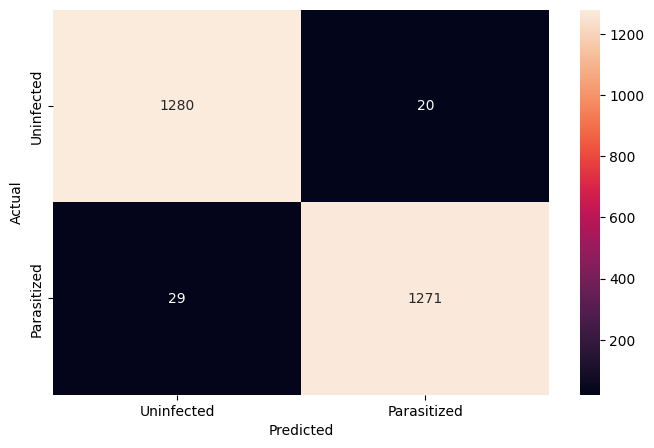

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred3 = model3.predict(test_images)

pred3 = np.argmax(pred3, axis = 1)

y_true3 = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true3, pred3))

# Plotting the heatmap using confusion matrix
cm3 = confusion_matrix(y_true3, pred3)

plt.figure(figsize = (8, 5))

sns.heatmap(cm3, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

**Plotting the train and validation accuracy**

In [ ]:
# Plotting the accuracies

def plot_accuracy(history3):

    N3 = len(history3.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N3), history3.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N3), history3.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

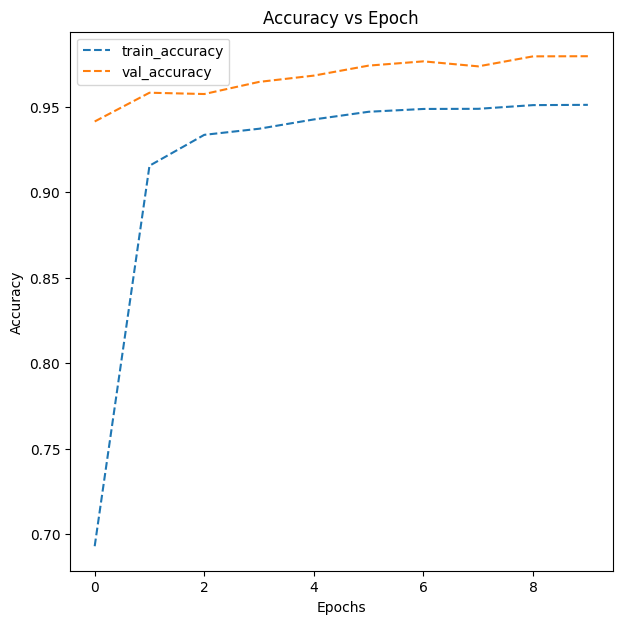

In [ ]:
plot_accuracy(history3)

**Pre-trained model (VGG16)**

In [ ]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (64, 64, 3))

vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Add classification layers on top of it
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons
x = BatchNormalization()(x)

pred = Dense(2, activation = 'softmax')(x)



In [ ]:
model4 = Model(vgg.input, pred) # Initializing the model

**Compilling Model 4**

In [ ]:
opt = SGD(0.001, momentum=0.9)


model4.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])





**Using callbacks**

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]



**Fit and Train the model**

In [ ]:
# Fitting the model and running the model for 10 epochs
from sklearn.model_selection import train_test_split


history4 = model4.fit(train_images, train_labels, batch_size = 32,  callbacks = callbacks, validation_split = 0.2, epochs = 10, verbose = 1)





Epoch 1/10
624/624 [==============================] - 1318s 2s/step - loss: 0.3195 - accuracy: 0.8800 - val_loss: 0.2619 - val_accuracy: 0.8964
Epoch 2/10
624/624 [==============================] - 1381s 2s/step - loss: 0.2460 - accuracy: 0.9117 - val_loss: 0.1799 - val_accuracy: 0.9423
Epoch 3/10
624/624 [==============================] - 1313s 2s/step - loss: 0.2288 - accuracy: 0.9144 - val_loss: 0.1482 - val_accuracy: 0.9633
Epoch 4/10
624/624 [==============================] - 1387s 2s/step - loss: 0.2202 - accuracy: 0.9172 - val_loss: 0.1708 - val_accuracy: 0.9583
Epoch 5/10
624/624 [==============================] - 1316s 2s/step - loss: 0.2011 - accuracy: 0.9258 - val_loss: 0.2839 - val_accuracy: 0.9095


**Plot the train and validation accuracy**

In [ ]:
accuracy4 = model4.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy4[1])

82/82 [==============================] - 136s 2s/step - loss: 0.2410 - accuracy: 0.9065

 Test_Accuracy:- 0.9065384864807129


**Plotting the Confusion Matrix**

82/82 [==============================] - 136s 2s/step
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1300
           1       0.86      0.97      0.91      1300

    accuracy                           0.91      2600
   macro avg       0.91      0.91      0.91      2600
weighted avg       0.91      0.91      0.91      2600



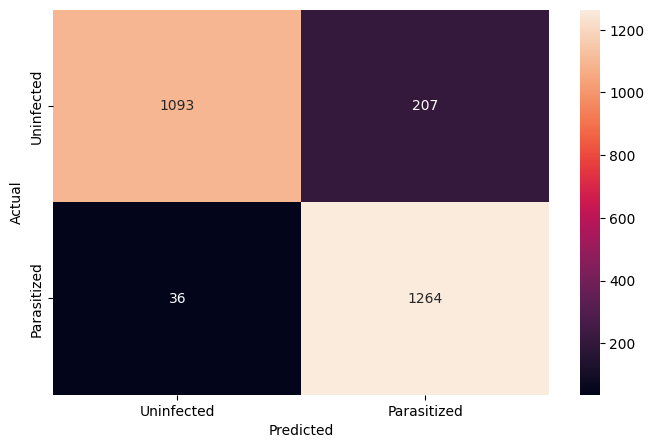

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred4 = model4.predict(test_images)

pred4 = np.argmax(pred4, axis = 1)

y_true4 = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true4, pred4))

# Plotting the heatmap using confusion matrix
cm4 = confusion_matrix(y_true4, pred4)

plt.figure(figsize = (8, 5))

sns.heatmap(cm4, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

**Plot Train and Validation Accuracy**

In [ ]:
# Plotting the accuracies

def plot_accuracy(history4):

    N4 = len(history4.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N4), history4.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N4), history4.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

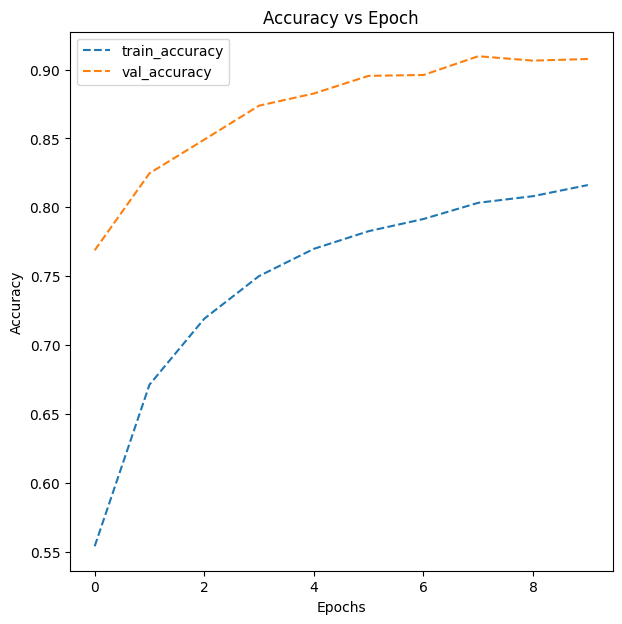

In [ ]:
plot_accuracy(history4)